In [2]:
!pip install diffusers
!pip install ipdb

In [1]:
# Copyright 2025 Black Forest Labs and The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import abc
import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import numpy as np
import torch
from transformers import (
    CLIPImageProcessor,
    CLIPTextModel,
    CLIPTokenizer,
    CLIPVisionModelWithProjection,
    T5EncoderModel,
    T5TokenizerFast,
)

from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.loaders import FluxIPAdapterMixin, FluxLoraLoaderMixin, FromSingleFileMixin, TextualInversionLoaderMixin
from diffusers.models.autoencoders import AutoencoderKL
from diffusers.models.transformers import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_output import FluxPipelineOutput
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from diffusers.utils import (
    USE_PEFT_BACKEND,
    deprecate,
    is_torch_xla_available,
    logging,
    replace_example_docstring,
    scale_lora_layers,
    unscale_lora_layers,
)
from diffusers.utils.torch_utils import randn_tensor

from diffusers.models.embeddings import apply_rotary_emb
from diffusers.models.transformers.transformer_flux import FluxAttention


if is_torch_xla_available():
    import torch_xla.core.xla_model as xm

    XLA_AVAILABLE = True
else:
    XLA_AVAILABLE = False

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

EXAMPLE_DOC_STRING = """
    Examples:
        ```py
        >>> import torch
        >>> from diffusers import DiffusionPipeline

        >>> pipe = DiffusionPipeline.from_pretrained(
        >>>     "black-forest-labs/FLUX.1-dev",
        >>>     custom_pipeline="pipeline_flux_semantic_guidance",
        >>>     torch_dtype=torch.bfloat16
        >>> )
        >>> pipe.to("cuda")
        >>> prompt = "A cat holding a sign that says hello world"
        >>> image = pipe(
        >>>     prompt=prompt,
        >>>     num_inference_steps=28,
        >>>     guidance_scale=3.5,
        >>>     editing_prompt=["cat", "dog"],  # changes from cat to dog.
        >>>     reverse_editing_direction=[True, False],
        >>>     edit_warmup_steps=[6, 8],
        >>>     edit_guidance_scale=[6, 6.5],
        >>>     edit_threshold=[0.89, 0.89],
        >>>     edit_cooldown_steps = [25, 27],
        >>>     edit_momentum_scale=0.3,
        >>>     edit_mom_beta=0.6,
        >>>     generator=torch.Generator(device="cuda").manual_seed(6543),
        >>> ).images[0]
        >>> image.save("semantic_flux.png")
        ```
"""


# Copied from diffusers.pipelines.flux.pipeline_flux.calculate_shift
def calculate_shift(
    image_seq_len,
    base_seq_len: int = 256,
    max_seq_len: int = 4096,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
):
    m = (max_shift - base_shift) / (max_seq_len - base_seq_len)
    b = base_shift - m * base_seq_len
    mu = image_seq_len * m + b
    return mu


# Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    sigmas: Optional[List[float]] = None,
    **kwargs,
):
    r"""
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
            Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
            `num_inference_steps` and `sigmas` must be `None`.
        sigmas (`List[float]`, *optional*):
            Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
            `num_inference_steps` and `timesteps` must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None and sigmas is not None:
        raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    elif sigmas is not None:
        accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
        if not accept_sigmas:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" sigmas schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps


class FluxPrompt2PromptPipeline(
    DiffusionPipeline,
    FluxLoraLoaderMixin,
    FromSingleFileMixin,
    TextualInversionLoaderMixin,
    FluxIPAdapterMixin,
):
    r"""
    The Flux pipeline for text-to-image generation.

    Reference: https://blackforestlabs.ai/announcing-black-forest-labs/

    Args:
        transformer ([`FluxTransformer2DModel`]):
            Conditional Transformer (MMDiT) architecture to denoise the encoded image latents.
        scheduler ([`FlowMatchEulerDiscreteScheduler`]):
            A scheduler to be used in combination with `transformer` to denoise the encoded image latents.
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        text_encoder_2 ([`T5EncoderModel`]):
            [T5](https://huggingface.co/docs/transformers/en/model_doc/t5#transformers.T5EncoderModel), specifically
            the [google/t5-v1_1-xxl](https://huggingface.co/google/t5-v1_1-xxl) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/en/model_doc/clip#transformers.CLIPTokenizer).
        tokenizer_2 (`T5TokenizerFast`):
            Second Tokenizer of class
            [T5TokenizerFast](https://huggingface.co/docs/transformers/en/model_doc/t5#transformers.T5TokenizerFast).
    """

    model_cpu_offload_seq = "text_encoder->text_encoder_2->image_encoder->transformer->vae"
    _optional_components = ["image_encoder", "feature_extractor"]
    _callback_tensor_inputs = ["latents", "prompt_embeds"]

    def __init__(
        self,
        scheduler: FlowMatchEulerDiscreteScheduler,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        text_encoder_2: T5EncoderModel,
        tokenizer_2: T5TokenizerFast,
        transformer: FluxTransformer2DModel,
        image_encoder: CLIPVisionModelWithProjection = None,
        feature_extractor: CLIPImageProcessor = None,
    ):
        super().__init__()

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            text_encoder_2=text_encoder_2,
            tokenizer=tokenizer,
            tokenizer_2=tokenizer_2,
            transformer=transformer,
            scheduler=scheduler,
            image_encoder=image_encoder,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1) if getattr(self, "vae", None) else 8
        # Flux latents are turned into 2x2 patches and packed. This means the latent width and height has to be divisible
        # by the patch size. So the vae scale factor is multiplied by the patch size to account for this
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor * 2)
        self.tokenizer_max_length = (
            self.tokenizer.model_max_length if hasattr(self, "tokenizer") and self.tokenizer is not None else 77
        )
        self.default_sample_size = 128

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline._get_t5_prompt_embeds
    def _get_t5_prompt_embeds(
        self,
        prompt: Union[str, List[str]] = None,
        num_images_per_prompt: int = 1,
        max_sequence_length: int = 512,
        device: Optional[torch.device] = None,
        dtype: Optional[torch.dtype] = None,
    ):
        device = device or self._execution_device
        dtype = dtype or self.text_encoder.dtype

        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        if isinstance(self, TextualInversionLoaderMixin):
            prompt = self.maybe_convert_prompt(prompt, self.tokenizer_2)

        text_inputs = self.tokenizer_2(
            prompt,
            padding="max_length",
            max_length=max_sequence_length,
            truncation=True,
            return_length=False,
            return_overflowing_tokens=False,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer_2(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
            removed_text = self.tokenizer_2.batch_decode(untruncated_ids[:, self.tokenizer_max_length - 1 : -1])
            logger.warning(
                "The following part of your input was truncated because `max_sequence_length` is set to "
                f" {max_sequence_length} tokens: {removed_text}"
            )

        prompt_embeds = self.text_encoder_2(text_input_ids.to(device), output_hidden_states=False)[0]

        dtype = self.text_encoder_2.dtype
        prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

        _, seq_len, _ = prompt_embeds.shape

        # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline._get_clip_prompt_embeds
    def _get_clip_prompt_embeds(
        self,
        prompt: Union[str, List[str]],
        num_images_per_prompt: int = 1,
        device: Optional[torch.device] = None,
    ):
        device = device or self._execution_device

        prompt = [prompt] if isinstance(prompt, str) else prompt
        batch_size = len(prompt)

        if isinstance(self, TextualInversionLoaderMixin):
            prompt = self.maybe_convert_prompt(prompt, self.tokenizer)

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer_max_length,
            truncation=True,
            return_overflowing_tokens=False,
            return_length=False,
            return_tensors="pt",
        )

        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids
        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
            removed_text = self.tokenizer.batch_decode(untruncated_ids[:, self.tokenizer_max_length - 1 : -1])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer_max_length} tokens: {removed_text}"
            )
        prompt_embeds = self.text_encoder(text_input_ids.to(device), output_hidden_states=False)

        # Use pooled output of CLIPTextModel
        prompt_embeds = prompt_embeds.pooler_output
        prompt_embeds = prompt_embeds.to(dtype=self.text_encoder.dtype, device=device)

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt)
        prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, -1)

        return prompt_embeds

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.encode_prompt
    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        prompt_2: Optional[Union[str, List[str]]] = None,
        device: Optional[torch.device] = None,
        num_images_per_prompt: int = 1,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        max_sequence_length: int = 512,
        lora_scale: Optional[float] = None,
    ):
        r"""

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to the `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                used in all text-encoders
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            lora_scale (`float`, *optional*):
                A lora scale that will be applied to all LoRA layers of the text encoder if LoRA layers are loaded.
        """
        device = device or self._execution_device

        # set lora scale so that monkey patched LoRA
        # function of text encoder can correctly access it
        if lora_scale is not None and isinstance(self, FluxLoraLoaderMixin):
            self._lora_scale = lora_scale

            # dynamically adjust the LoRA scale
            if self.text_encoder is not None and USE_PEFT_BACKEND:
                scale_lora_layers(self.text_encoder, lora_scale)
            if self.text_encoder_2 is not None and USE_PEFT_BACKEND:
                scale_lora_layers(self.text_encoder_2, lora_scale)

        prompt = [prompt] if isinstance(prompt, str) else prompt

        if prompt_embeds is None:
            prompt_2 = prompt_2 or prompt
            prompt_2 = [prompt_2] if isinstance(prompt_2, str) else prompt_2

            # We only use the pooled prompt output from the CLIPTextModel
            pooled_prompt_embeds = self._get_clip_prompt_embeds(
                prompt=prompt,
                device=device,
                num_images_per_prompt=num_images_per_prompt,
            )
            prompt_embeds = self._get_t5_prompt_embeds(
                prompt=prompt_2,
                num_images_per_prompt=num_images_per_prompt,
                max_sequence_length=max_sequence_length,
                device=device,
            )

        if self.text_encoder is not None:
            if isinstance(self, FluxLoraLoaderMixin) and USE_PEFT_BACKEND:
                # Retrieve the original scale by scaling back the LoRA layers
                unscale_lora_layers(self.text_encoder, lora_scale)

        if self.text_encoder_2 is not None:
            if isinstance(self, FluxLoraLoaderMixin) and USE_PEFT_BACKEND:
                # Retrieve the original scale by scaling back the LoRA layers
                unscale_lora_layers(self.text_encoder_2, lora_scale)

        dtype = self.text_encoder.dtype if self.text_encoder is not None else self.transformer.dtype
        text_ids = torch.zeros(prompt_embeds.shape[1], 3).to(device=device, dtype=dtype)

        return prompt_embeds, pooled_prompt_embeds, text_ids

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.encode_image
    def encode_image(self, image, device, num_images_per_prompt):
        dtype = next(self.image_encoder.parameters()).dtype

        if not isinstance(image, torch.Tensor):
            image = self.feature_extractor(image, return_tensors="pt").pixel_values

        image = image.to(device=device, dtype=dtype)
        image_embeds = self.image_encoder(image).image_embeds
        image_embeds = image_embeds.repeat_interleave(num_images_per_prompt, dim=0)
        return image_embeds

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.prepare_ip_adapter_image_embeds
    def prepare_ip_adapter_image_embeds(
        self, ip_adapter_image, ip_adapter_image_embeds, device, num_images_per_prompt
    ):
        image_embeds = []
        if ip_adapter_image_embeds is None:
            if not isinstance(ip_adapter_image, list):
                ip_adapter_image = [ip_adapter_image]

            if len(ip_adapter_image) != self.transformer.encoder_hid_proj.num_ip_adapters:
                raise ValueError(
                    f"`ip_adapter_image` must have same length as the number of IP Adapters. Got {len(ip_adapter_image)} images and {self.transformer.encoder_hid_proj.num_ip_adapters} IP Adapters."
                )

            for single_ip_adapter_image in ip_adapter_image:
                single_image_embeds = self.encode_image(single_ip_adapter_image, device, 1)
                image_embeds.append(single_image_embeds[None, :])
        else:
            if not isinstance(ip_adapter_image_embeds, list):
                ip_adapter_image_embeds = [ip_adapter_image_embeds]

            if len(ip_adapter_image_embeds) != self.transformer.encoder_hid_proj.num_ip_adapters:
                raise ValueError(
                    f"`ip_adapter_image_embeds` must have same length as the number of IP Adapters. Got {len(ip_adapter_image_embeds)} image embeds and {self.transformer.encoder_hid_proj.num_ip_adapters} IP Adapters."
                )

            for single_image_embeds in ip_adapter_image_embeds:
                image_embeds.append(single_image_embeds)

        ip_adapter_image_embeds = []
        for single_image_embeds in image_embeds:
            single_image_embeds = torch.cat([single_image_embeds] * num_images_per_prompt, dim=0)
            single_image_embeds = single_image_embeds.to(device=device)
            ip_adapter_image_embeds.append(single_image_embeds)

        return ip_adapter_image_embeds

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.check_inputs
    def check_inputs(
        self,
        prompt,
        prompt_2,
        height,
        width,
        negative_prompt=None,
        negative_prompt_2=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        pooled_prompt_embeds=None,
        negative_pooled_prompt_embeds=None,
        callback_on_step_end_tensor_inputs=None,
        max_sequence_length=None,
    ):
        if height % (self.vae_scale_factor * 2) != 0 or width % (self.vae_scale_factor * 2) != 0:
            logger.warning(
                f"`height` and `width` have to be divisible by {self.vae_scale_factor * 2} but are {height} and {width}. Dimensions will be resized accordingly"
            )

        if callback_on_step_end_tensor_inputs is not None and not all(
            k in self._callback_tensor_inputs for k in callback_on_step_end_tensor_inputs
        ):
            raise ValueError(
                f"`callback_on_step_end_tensor_inputs` has to be in {self._callback_tensor_inputs}, but found {[k for k in callback_on_step_end_tensor_inputs if k not in self._callback_tensor_inputs]}"
            )

        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt_2 is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt_2`: {prompt_2} and `prompt_embeds`: {prompt_embeds}. Please make sure to"
                " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError(
                "Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined."
            )
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")
        elif prompt_2 is not None and (not isinstance(prompt_2, str) and not isinstance(prompt_2, list)):
            raise ValueError(f"`prompt_2` has to be of type `str` or `list` but is {type(prompt_2)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )
        elif negative_prompt_2 is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt_2`: {negative_prompt_2} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and pooled_prompt_embeds is None:
            raise ValueError(
                "If `prompt_embeds` are provided, `pooled_prompt_embeds` also have to be passed. Make sure to generate `pooled_prompt_embeds` from the same text encoder that was used to generate `prompt_embeds`."
            )
        if negative_prompt_embeds is not None and negative_pooled_prompt_embeds is None:
            raise ValueError(
                "If `negative_prompt_embeds` are provided, `negative_pooled_prompt_embeds` also have to be passed. Make sure to generate `negative_pooled_prompt_embeds` from the same text encoder that was used to generate `negative_prompt_embeds`."
            )

        if max_sequence_length is not None and max_sequence_length > 512:
            raise ValueError(f"`max_sequence_length` cannot be greater than 512 but is {max_sequence_length}")

    @staticmethod
    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline._prepare_latent_image_ids
    def _prepare_latent_image_ids(batch_size, height, width, device, dtype):
        latent_image_ids = torch.zeros(height, width, 3)
        latent_image_ids[..., 1] = latent_image_ids[..., 1] + torch.arange(height)[:, None]
        latent_image_ids[..., 2] = latent_image_ids[..., 2] + torch.arange(width)[None, :]

        latent_image_id_height, latent_image_id_width, latent_image_id_channels = latent_image_ids.shape

        latent_image_ids = latent_image_ids.reshape(
            latent_image_id_height * latent_image_id_width, latent_image_id_channels
        )

        return latent_image_ids.to(device=device, dtype=dtype)

    @staticmethod
    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline._pack_latents
    def _pack_latents(latents, batch_size, num_channels_latents, height, width):
        latents = latents.view(batch_size, num_channels_latents, height // 2, 2, width // 2, 2)
        latents = latents.permute(0, 2, 4, 1, 3, 5)
        latents = latents.reshape(batch_size, (height // 2) * (width // 2), num_channels_latents * 4)

        return latents

    @staticmethod
    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline._unpack_latents
    def _unpack_latents(latents, height, width, vae_scale_factor):
        batch_size, num_patches, channels = latents.shape

        # VAE applies 8x compression on images but we must also account for packing which requires
        # latent height and width to be divisible by 2.
        height = 2 * (int(height) // (vae_scale_factor * 2))
        width = 2 * (int(width) // (vae_scale_factor * 2))

        latents = latents.view(batch_size, height // 2, width // 2, channels // 4, 2, 2)
        latents = latents.permute(0, 3, 1, 4, 2, 5)

        latents = latents.reshape(batch_size, channels // (2 * 2), height, width)

        return latents

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.enable_vae_slicing
    def enable_vae_slicing(self):
        r"""
        Enable sliced VAE decoding. When this option is enabled, the VAE will split the input tensor in slices to
        compute decoding in several steps. This is useful to save some memory and allow larger batch sizes.
        """
        self.vae.enable_slicing()

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.disable_vae_slicing
    def disable_vae_slicing(self):
        r"""
        Disable sliced VAE decoding. If `enable_vae_slicing` was previously enabled, this method will go back to
        computing decoding in one step.
        """
        self.vae.disable_slicing()

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.enable_vae_tiling
    def enable_vae_tiling(self):
        r"""
        Enable tiled VAE decoding. When this option is enabled, the VAE will split the input tensor into tiles to
        compute decoding and encoding in several steps. This is useful for saving a large amount of memory and to allow
        processing larger images.
        """
        depr_message = f"Calling `enable_vae_tiling()` on a `{self.__class__.__name__}` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_tiling()`."
        deprecate(
            "enable_vae_tiling",
            "0.40.0",
            depr_message,
        )
        self.vae.enable_tiling()

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.disable_vae_tiling
    def disable_vae_tiling(self):
        r"""
        Disable tiled VAE decoding. If `enable_vae_tiling` was previously enabled, this method will go back to
        computing decoding in one step.
        """
        depr_message = f"Calling `disable_vae_tiling()` on a `{self.__class__.__name__}` is deprecated and this method will be removed in a future version. Please use `pipe.vae.disable_tiling()`."
        deprecate(
            "disable_vae_tiling",
            "0.40.0",
            depr_message,
        )
        self.vae.disable_tiling()

    # Copied from diffusers.pipelines.flux.pipeline_flux.FluxPipeline.prepare_latents
    def prepare_latents(
        self,
        batch_size,
        num_channels_latents,
        height,
        width,
        dtype,
        device,
        generator,
        latents=None,
    ):
        # VAE applies 8x compression on images but we must also account for packing which requires
        # latent height and width to be divisible by 2.
        height = 2 * (int(height) // (self.vae_scale_factor * 2))
        width = 2 * (int(width) // (self.vae_scale_factor * 2))

        shape = (batch_size, num_channels_latents, height, width)

        if latents is not None:
            latent_image_ids = self._prepare_latent_image_ids(batch_size, height // 2, width // 2, device, dtype)
            return latents.to(device=device, dtype=dtype), latent_image_ids

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        latents = randn_tensor(shape, generator=generator, device=device, dtype=dtype)
        latents = self._pack_latents(latents, batch_size, num_channels_latents, height, width)

        latent_image_ids = self._prepare_latent_image_ids(batch_size, height // 2, width // 2, device, dtype)

        return latents, latent_image_ids

    @property
    def guidance_scale(self):
        return self._guidance_scale

    @property
    def joint_attention_kwargs(self):
        return self._joint_attention_kwargs

    @property
    def num_timesteps(self):
        return self._num_timesteps

    @property
    def current_timestep(self):
        return self._current_timestep

    @property
    def interrupt(self):
        return self._interrupt

    @torch.no_grad()
    @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        negative_prompt: Union[str, List[str]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        true_cfg_scale: float = 1.0,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 28,
        sigmas: Optional[List[float]] = None,
        guidance_scale: float = 3.5,
        num_images_per_prompt: Optional[int] = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        negative_ip_adapter_image: Optional[PipelineImageInput] = None,
        negative_ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        joint_attention_kwargs: Optional[Dict[str, Any]] = None,
        callback_on_step_end: Optional[Callable[[int, int, Dict], None]] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        max_sequence_length: int = 512,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts to be sent to `tokenizer_2` and `text_encoder_2`. If not defined, `prompt` is
                will be used instead.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `true_cfg_scale` is
                not greater than `1`).
            negative_prompt_2 (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation to be sent to `tokenizer_2` and
                `text_encoder_2`. If not defined, `negative_prompt` is used in all the text-encoders.
            true_cfg_scale (`float`, *optional*, defaults to 1.0):
                True classifier-free guidance (guidance scale) is enabled when `true_cfg_scale` > 1 and
                `negative_prompt` is provided.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image. This is set to 1024 by default for the best results.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image. This is set to 1024 by default for the best results.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 3.5):
                Embedded guiddance scale is enabled by setting `guidance_scale` > 1. Higher `guidance_scale` encourages
                a model to generate images more aligned with `prompt` at the expense of lower image quality.

                Guidance-distilled models approximates true classifer-free guidance for `guidance_scale` > 1. Refer to
                the [paper](https://huggingface.co/papers/2210.03142) to learn more.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will be generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting.
                If not provided, pooled text embeddings will be generated from `prompt` input argument.
            ip_adapter_image: (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
            ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
                Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
                IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. If not
                provided, embeddings are computed from the `ip_adapter_image` input argument.
            negative_ip_adapter_image:
                (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
            negative_ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
                Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
                IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. If not
                provided, embeddings are computed from the `ip_adapter_image` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            negative_pooled_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative pooled text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, pooled negative_prompt_embeds will be generated from `negative_prompt`
                input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.flux.FluxPipelineOutput`] instead of a plain tuple.
            joint_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            callback_on_step_end (`Callable`, *optional*):
                A function that calls at the end of each denoising steps during the inference. The function is called
                with the following arguments: `callback_on_step_end(self: DiffusionPipeline, step: int, timestep: int,
                callback_kwargs: Dict)`. `callback_kwargs` will include a list of all tensors as specified by
                `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeline class.
            max_sequence_length (`int` defaults to 512): Maximum sequence length to use with the `prompt`.

        Examples:

        Returns:
            [`~pipelines.flux.FluxPipelineOutput`] or `tuple`: [`~pipelines.flux.FluxPipelineOutput`] if `return_dict`
            is True, otherwise a `tuple`. When returning a tuple, the first element is a list with the generated
            images.
        """

        self.controller = AttentionStore(
            len(self.transformer.transformer_blocks),
            len(self.transformer.single_transformer_blocks),
            num_inference_steps,
        )
        self.register_attention_control(self.controller)

        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            callback_on_step_end_tensor_inputs=callback_on_step_end_tensor_inputs,
            max_sequence_length=max_sequence_length,
        )

        self._guidance_scale = guidance_scale
        self._joint_attention_kwargs = joint_attention_kwargs
        self._current_timestep = None
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        lora_scale = (
            self.joint_attention_kwargs.get("scale", None) if self.joint_attention_kwargs is not None else None
        )
        has_neg_prompt = negative_prompt is not None or (
            negative_prompt_embeds is not None and negative_pooled_prompt_embeds is not None
        )
        do_true_cfg = true_cfg_scale > 1 and has_neg_prompt
        (
            prompt_embeds,
            pooled_prompt_embeds,
            text_ids,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            prompt_embeds=prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            max_sequence_length=max_sequence_length,
            lora_scale=lora_scale,
        )
        if do_true_cfg:
            (
                negative_prompt_embeds,
                negative_pooled_prompt_embeds,
                negative_text_ids,
            ) = self.encode_prompt(
                prompt=negative_prompt,
                prompt_2=negative_prompt_2,
                prompt_embeds=negative_prompt_embeds,
                pooled_prompt_embeds=negative_pooled_prompt_embeds,
                device=device,
                num_images_per_prompt=num_images_per_prompt,
                max_sequence_length=max_sequence_length,
                lora_scale=lora_scale,
            )

        # 4. Prepare latent variables
        num_channels_latents = self.transformer.config.in_channels // 4
        latents, latent_image_ids = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 5. Prepare timesteps
        sigmas = np.linspace(1.0, 1 / num_inference_steps, num_inference_steps) if sigmas is None else sigmas
        if hasattr(self.scheduler.config, "use_flow_sigmas") and self.scheduler.config.use_flow_sigmas:
            sigmas = None
        image_seq_len = latents.shape[1]
        mu = calculate_shift(
            image_seq_len,
            self.scheduler.config.get("base_image_seq_len", 256),
            self.scheduler.config.get("max_image_seq_len", 4096),
            self.scheduler.config.get("base_shift", 0.5),
            self.scheduler.config.get("max_shift", 1.15),
        )
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler,
            num_inference_steps,
            device,
            sigmas=sigmas,
            mu=mu,
        )
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)
        self._num_timesteps = len(timesteps)

        # handle guidance
        if self.transformer.config.guidance_embeds:
            guidance = torch.full([1], guidance_scale, device=device, dtype=torch.float32)
            guidance = guidance.expand(latents.shape[0])
        else:
            guidance = None

        if (ip_adapter_image is not None or ip_adapter_image_embeds is not None) and (
            negative_ip_adapter_image is None and negative_ip_adapter_image_embeds is None
        ):
            negative_ip_adapter_image = np.zeros((width, height, 3), dtype=np.uint8)
            negative_ip_adapter_image = [negative_ip_adapter_image] * self.transformer.encoder_hid_proj.num_ip_adapters

        elif (ip_adapter_image is None and ip_adapter_image_embeds is None) and (
            negative_ip_adapter_image is not None or negative_ip_adapter_image_embeds is not None
        ):
            ip_adapter_image = np.zeros((width, height, 3), dtype=np.uint8)
            ip_adapter_image = [ip_adapter_image] * self.transformer.encoder_hid_proj.num_ip_adapters

        if self.joint_attention_kwargs is None:
            self._joint_attention_kwargs = {}

        image_embeds = None
        negative_image_embeds = None
        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
            )
        if negative_ip_adapter_image is not None or negative_ip_adapter_image_embeds is not None:
            negative_image_embeds = self.prepare_ip_adapter_image_embeds(
                negative_ip_adapter_image,
                negative_ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
            )

        # 6. Denoising loop
        # We set the index here to remove DtoH sync, helpful especially during compilation.
        # Check out more details here: https://github.com/huggingface/diffusers/pull/11696
        self.scheduler.set_begin_index(0)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                self._current_timestep = t
                if image_embeds is not None:
                    self._joint_attention_kwargs["ip_adapter_image_embeds"] = image_embeds
                # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
                timestep = t.expand(latents.shape[0]).to(latents.dtype)

                with self.transformer.cache_context("cond"):
                    noise_pred = self.transformer(
                        hidden_states=latents,
                        timestep=timestep / 1000,
                        guidance=guidance,
                        pooled_projections=pooled_prompt_embeds,
                        encoder_hidden_states=prompt_embeds,
                        txt_ids=text_ids,
                        img_ids=latent_image_ids,
                        joint_attention_kwargs=self.joint_attention_kwargs,
                        return_dict=False,
                    )[0]

                if do_true_cfg:
                    if negative_image_embeds is not None:
                        self._joint_attention_kwargs["ip_adapter_image_embeds"] = negative_image_embeds

                    with self.transformer.cache_context("uncond"):
                        neg_noise_pred = self.transformer(
                            hidden_states=latents,
                            timestep=timestep / 1000,
                            guidance=guidance,
                            pooled_projections=negative_pooled_prompt_embeds,
                            encoder_hidden_states=negative_prompt_embeds,
                            txt_ids=negative_text_ids,
                            img_ids=latent_image_ids,
                            joint_attention_kwargs=self.joint_attention_kwargs,
                            return_dict=False,
                        )[0]
                    noise_pred = neg_noise_pred + true_cfg_scale * (noise_pred - neg_noise_pred)

                # compute the previous noisy sample x_t -> x_t-1
                latents_dtype = latents.dtype
                latents = self.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

                if latents.dtype != latents_dtype:
                    if torch.backends.mps.is_available():
                        # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                        latents = latents.to(latents_dtype)

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)

                # step callback
                latents = self.controller.step_callback(latents, is_last_step=(i == len(timesteps) - 1))

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

                if XLA_AVAILABLE:
                    xm.mark_step()

        self._current_timestep = None

        if output_type == "latent":
            image = latents
        else:
            latents = self._unpack_latents(latents, height, width, self.vae_scale_factor)
            latents = (latents / self.vae.config.scaling_factor) + self.vae.config.shift_factor
            image = self.vae.decode(latents, return_dict=False)[0]
            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return FluxPipelineOutput(images=image)

    def register_attention_control(self, controller):
        for i, tblock in enumerate(self.transformer.transformer_blocks):
            attn_proc = P2PFluxAttnProcessor(controller=controller, is_single=False, index=i)
            tblock.attn.set_processor(attn_proc)
        for i, tblock in enumerate(self.transformer.single_transformer_blocks):
            attn_proc = P2PFluxAttnProcessor(controller=controller, is_single=True, index=i)
            tblock.attn.set_processor(attn_proc)


# copied from diffusers.models.transformers.transformer_flux._get_projections
def _get_projections(attn: "FluxAttention", hidden_states, encoder_hidden_states=None):
    query = attn.to_q(hidden_states)
    key = attn.to_k(hidden_states)
    value = attn.to_v(hidden_states)

    encoder_query = encoder_key = encoder_value = None
    if encoder_hidden_states is not None and attn.added_kv_proj_dim is not None:
        encoder_query = attn.add_q_proj(encoder_hidden_states)
        encoder_key = attn.add_k_proj(encoder_hidden_states)
        encoder_value = attn.add_v_proj(encoder_hidden_states)

    return query, key, value, encoder_query, encoder_key, encoder_value


# copied from diffusers.models.transformers.transformer_flux._get_fused_projections
def _get_fused_projections(attn: "FluxAttention", hidden_states, encoder_hidden_states=None):
    query, key, value = attn.to_qkv(hidden_states).chunk(3, dim=-1)

    encoder_query = encoder_key = encoder_value = (None,)
    if encoder_hidden_states is not None and hasattr(attn, "to_added_qkv"):
        encoder_query, encoder_key, encoder_value = attn.to_added_qkv(encoder_hidden_states).chunk(3, dim=-1)

    return query, key, value, encoder_query, encoder_key, encoder_value


# copied from diffusers.models.transformers.transformer_flux._get_qkv_projections
def _get_qkv_projections(attn: "FluxAttention", hidden_states, encoder_hidden_states=None):
    if attn.fused_projections:
        return _get_fused_projections(attn, hidden_states, encoder_hidden_states)
    return _get_projections(attn, hidden_states, encoder_hidden_states)


class P2PFluxAttnProcessor:
    _attention_backend = None
    _parallel_config = None

    def __init__(self, controller, is_single, index):
        super().__init__()
        self.controller = controller
        self.is_single = is_single
        self.index = index

    def __call__(
        self,
        attn: "FluxAttention",
        hidden_states: torch.Tensor,
        encoder_hidden_states: torch.Tensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        image_rotary_emb: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        query, key, value, encoder_query, encoder_key, encoder_value = _get_qkv_projections(
            attn, hidden_states, encoder_hidden_states
        )

        query = query.unflatten(-1, (attn.heads, -1))
        key = key.unflatten(-1, (attn.heads, -1))
        value = value.unflatten(-1, (attn.heads, -1))

        query = attn.norm_q(query)
        key = attn.norm_k(key)

        if attn.added_kv_proj_dim is not None:
            encoder_query = encoder_query.unflatten(-1, (attn.heads, -1))
            encoder_key = encoder_key.unflatten(-1, (attn.heads, -1))
            encoder_value = encoder_value.unflatten(-1, (attn.heads, -1))

            encoder_query = attn.norm_added_q(encoder_query)
            encoder_key = attn.norm_added_k(encoder_key)

            query = torch.cat([encoder_query, query], dim=1)
            key = torch.cat([encoder_key, key], dim=1)
            value = torch.cat([encoder_value, value], dim=1)

        if image_rotary_emb is not None:
            query = apply_rotary_emb(query, image_rotary_emb, sequence_dim=1)
            key = apply_rotary_emb(key, image_rotary_emb, sequence_dim=1)

        # q k v shape: (batch_size, seq_len, heads, head_dim) [1, 4608, 24, 128]
        # to use attn.get_attention_scores() we need to reshape to (batch_size * heads, seq_len, head_dim)
        batch_size, seq_len, heads, head_dim = query.shape
        query_reshaped = query.permute(0, 2, 1, 3).reshape(-1, query.shape[1], query.shape[3])
        key_reshaped = key.permute(0, 2, 1, 3).reshape(-1, key.shape[1], key.shape[3])
        value_reshaped = value.permute(0, 2, 1, 3).reshape(-1, value.shape[1], value.shape[3])

        # the original dispatch_attention_fn uses torch.nn.functional.scaled_dot_product_attention
        # which is highly optimized to be numerically stable in float16 or bfloat16 by using online softmax(?)
        # we don't have that. So we upcast to float32 here to be safe.
        attn.upcast_attention = True
        attn.upcast_softmax = True

        attn.scale = attn.head_dim**-0.5

        attention_probs = attn.get_attention_scores(
            query_reshaped,
            key_reshaped,
            attention_mask=attention_mask,
        )

        # one-liner
        self.controller(attention_probs, is_single = self.is_single, index = self.index)

        hidden_states = torch.bmm(attention_probs, value_reshaped)
        # hidden_states shape: (batch_size * heads, seq_len, head_dim)
        # reshape back to (batch_size, seq_len, heads, head_dim)
        hidden_states = hidden_states.view(batch_size, attn.heads, seq_len, attn.head_dim).permute(0, 2, 1, 3)
        # flatten heads and head_dim
        hidden_states = hidden_states.flatten(2, 3)
        hidden_states = hidden_states.to(query.dtype)

        if encoder_hidden_states is not None:
            encoder_hidden_states, hidden_states = hidden_states.split_with_sizes(
                [encoder_hidden_states.shape[1], hidden_states.shape[1] - encoder_hidden_states.shape[1]], dim=1
            )
            hidden_states = attn.to_out[0](hidden_states)
            hidden_states = attn.to_out[1](hidden_states)
            encoder_hidden_states = attn.to_add_out(encoder_hidden_states)

            return hidden_states, encoder_hidden_states
        else:
            return hidden_states


class AttentionControl(abc.ABC):
    def step_callback(self, x_t, is_last_step: bool):
        if not is_last_step:
            self.between_steps()
        return x_t

    def between_steps(self):
        return

    @abc.abstractmethod
    def forward(self, attn, is_single: bool, index):
        raise NotImplementedError

    def __call__(self, attn, is_single: bool, index):
        attn = self.forward(attn, is_single, index)
        return attn

    def __init__(self, num_att_layers, num_single_att_layers, num_inference_steps):
        self.num_att_layers = num_att_layers
        self.num_single_att_layers = num_single_att_layers
        self.num_inference_steps = num_inference_steps


class EmptyControl(AttentionControl):
    def forward(self, attn, is_single: bool, index):
        if is_single:
            print(f'single attn[{index}] processed, total {self.num_single_att_layers}')
        else:
            print(f'attn[{index}] processed, total {self.num_att_layers}')
        return attn


class AttentionStore(AttentionControl):
    def forward(self, attn, is_single: bool, index):
        if not is_single:
            # store attention maps for MM-DiT layers only
            # attn shape: (batch_size * heads, prompt_seq+latent_seq, prompt_seq+latent_seq)
            # here we assume batch_size=1 during inference
            # prompt_seq 512 for 77 tokens, latent_seq 4096 for 64x64 latent image
            # extract prompt->latent attention maps only
            heads, seq_len, _ = attn.shape
            prompt_seq_len = 512
            latent_seq_len = seq_len - prompt_seq_len
            prompt_to_latent_attn = attn[:, :prompt_seq_len, prompt_seq_len:]
            # now the shape is (batch_size * heads, prompt_seq, latent_seq) softmaxed over latent_seq
            # average over heads and self.num_att_layers and self.num_inference_steps
            prompt_to_latent_attn = prompt_to_latent_attn.mean(dim=0) / self.num_att_layers / self.num_inference_steps
            # now add to step_store, take average over self.num_att_layers
            if self.attention_store is None:
                self.attention_store = prompt_to_latent_attn
            else:
                self.attention_store += prompt_to_latent_attn
            del prompt_to_latent_attn
        return attn

    def __init__(self, num_att_layers, num_single_att_layers, num_inference_steps):
        super().__init__(num_att_layers, num_single_att_layers, num_inference_steps)
        self.attention_store = None


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [2]:
import torch
# from pipeline_p2p_flux import FluxPrompt2PromptPipeline

pipe = FluxPrompt2PromptPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", token=TOKEN, torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
# pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [3]:
prompt = "a furry bear watching a bird"
tokens = pipe.tokenizer_2(
            prompt,
            return_length=False,
            return_tensors="pt",
        ).input_ids.squeeze(0)

image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image.save("flux-dev.png")

  0%|          | 0/50 [00:00<?, ?it/s]

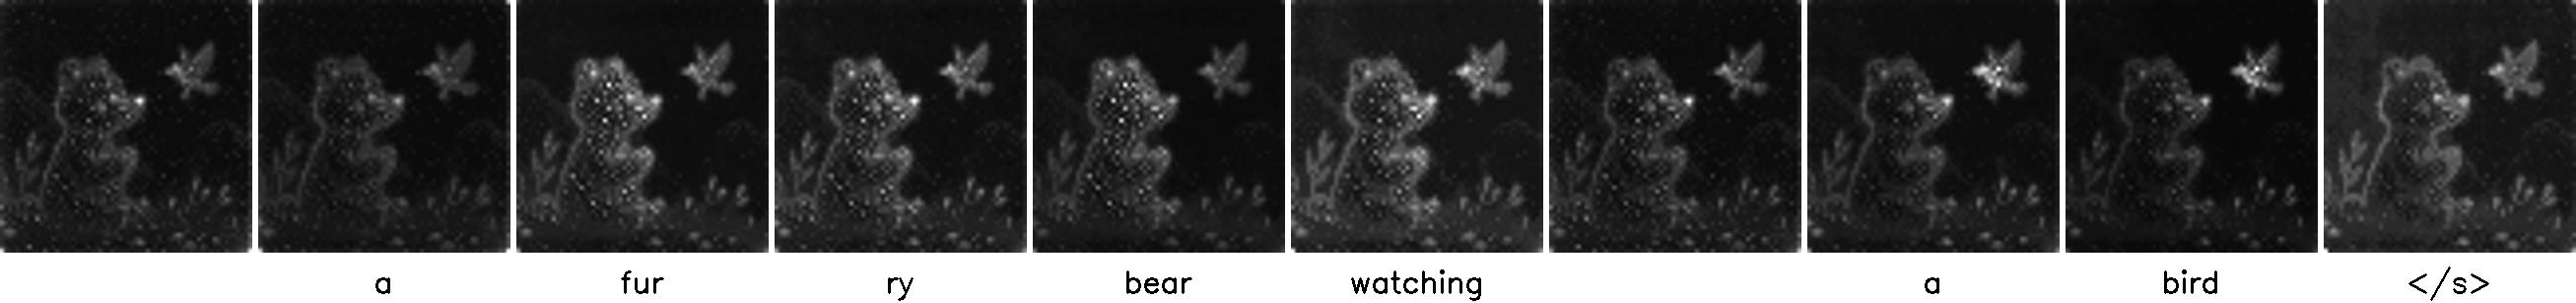

In [8]:
from PIL import Image, ImageDraw, ImageFont
from typing import Optional, Union, Tuple, List, Callable, Dict
import cv2
import ipdb

def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
    h, w, c = image.shape
    offset = int(h * .2)
    img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX
    # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
    img[:h] = image
    textsize = cv2.getTextSize(text, font, 1, 2)[0]
    text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
    cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
    return img


def view_images(images, num_rows=1, offset_ratio=0.02):
    if type(images) is list:
        num_empty = len(images) % num_rows
    elif images.ndim == 4:
        num_empty = images.shape[0] % num_rows
    else:
        images = [images]
        num_empty = 0

    empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
    images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
    num_items = len(images)

    h, w, c = images[0].shape
    offset = int(h * offset_ratio)
    num_cols = num_items // num_rows
    image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                      w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
    for i in range(num_rows):
        for j in range(num_cols):
            image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                i * num_cols + j]

    pil_img = Image.fromarray(image_)
    display(pil_img)

def show_cross_attention(attention_maps, tokens, decoder):
    images = []
    for i in range(len(tokens)):
        #ipdb.set_trace()
        image = attention_maps[i, :].reshape(64, 64)
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    view_images(np.stack(images, axis=0))

show_cross_attention(pipe.controller.attention_store.to(dtype=torch.float32).cpu().float(), tokens, pipe.tokenizer_2.decode)

In [9]:
print(tokens)

tensor([   3,    9, 4223,  651, 4595, 3355,    3,    9, 5963,    1])
